In [1]:
import operator
from pydantic import BaseModel, Field
from langgraph.graph import END, MessagesState, START, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_mistralai import ChatMistralAI
from IPython.display import Image, display

from dotenv import load_dotenv

load_dotenv()

llm = ChatMistralAI(model="mistral-medium-latest", temperature=0)

In [26]:
from pydantic import BaseModel, Field
from enum import Enum

class Objective(str, Enum):
    awareness = "Notoriété"
    acquisition = "Acquisition"
    sales = "vente"

    def __str__(self):
        return self.value

class Media(str, Enum):
    display = "Display"
    video = "Vidéo"
    social = "Social"

    def __str__(self):
        return self.value

class Context(BaseModel):
    end_target : str = Field(
        description="Informations à propos de la cible de la campagne marketing",
    )
    business_context : str = Field(
        description="Informations à propos du contexte commercial de la campagne marketing (ex: secteur d'activité, taille de l'entreprise, etc.)",
    )
    product_context : str = Field(
        description="Informations à propos du contexte produit de la campagne marketing",
    )
    
class CampaignObjectives(BaseModel):
    objectives : Objective
    media : Media
    context : Context
    


In [27]:
objectives_instructions = """
Tu es un expert en marketing digital.
Tu dois collecter les objectifs de la campagne marketing.
Tu dois collecter les médias utilisés pour la campagne marketing.
Tu dois collecter les contextes de la campagne marketing.
"""

In [28]:
class MyState(MessagesState):
    objectives : CampaignObjectives = None


def collect_campaign_objectives(state: MyState):
    message = state["messages"][0]
    structured_llm = llm.with_structured_output(CampaignObjectives)
    campaign_objectives =structured_llm.invoke([
        SystemMessage(content=objectives_instructions),
        message
        ])

    return {
        "objectives": campaign_objectives
        # "messages": [message]
    }

def collect_data(state: MyState):
    pass

def enrich_data(state: MyState):
    pass

def perform_clustering(state: MyState):
    pass

def generate_textual_personas(state: MyState):
    pass

def select_customer_segment(state: MyState):
    pass

def generate_visual_personas(state: MyState):
    pass 

def summarize_dsp_mappings(state: MyState):
    pass


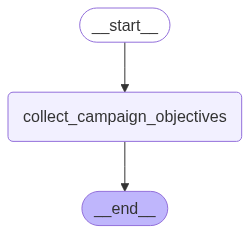

In [29]:
dsp = StateGraph(MyState)
dsp.add_node("collect_campaign_objectives", collect_campaign_objectives)
# dsp.add_node("collect data", collect_data)
# dsp.add_node("enrich data", enrich_data)
# dsp.add_node("perform clustering", perform_clustering)
# dsp.add_node("generate textual personas", generate_textual_personas)
# dsp.add_node("select customer segment", select_customer_segment)
# dsp.add_node("generate visual personas", generate_visual_personas)
# dsp.add_node("mapping suggestions", summarize_dsp_mappings)


dsp.add_edge(START, "collect_campaign_objectives")
# dsp.add_edge("collect_campaign_objectives", "collect data")
# dsp.add_edge("collect data", "enrich data")
# dsp.add_edge("enrich data", "perform clustering")
# dsp.add_edge("perform clustering", "generate textual personas")
# dsp.add_edge("generate textual personas", "select customer segment")
# dsp.add_edge("select customer segment", "generate visual personas")
# dsp.add_edge("generate visual personas", "mapping suggestions")


dsp.add_edge("collect_campaign_objectives", END)

graph = dsp.compile()
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
message = """
Je suis le directeur marketing d'un enseigne de distribution, équipement de la maison, grand public, je vends sur le web et en magasin.
On est haut de gamme. Ma clientéle est CSP+.
Je veux faire une campagne de recrutement de nouveaux clients sur un produit moyen gamme de façon à recruter autant sur les CSP que les CSP+. Je souhaite définir les paramètres pour ma campagne display sur Pmax de google."""

thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream({"messages" :message}, config=thread, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content="\nJe suis le directeur marketing d'un enseigne de distribution, équipement de la maison, grand public, je vends sur le web et en magasin.\nOn est haut de gamme. Ma clientéle est CSP+.\nJe veux faire une campagne de recrutement de nouveaux clients sur un produit moyen gamme de façon à recruter autant sur les CSP que les CSP+. Je souhaite définir les paramètres pour ma campagne display sur Pmax de google.", additional_kwargs={}, response_metadata={}, id='037d2390-ff46-4cc7-a46f-87fa93104924')]}
{'messages': [HumanMessage(content="\nJe suis le directeur marketing d'un enseigne de distribution, équipement de la maison, grand public, je vends sur le web et en magasin.\nOn est haut de gamme. Ma clientéle est CSP+.\nJe veux faire une campagne de recrutement de nouveaux clients sur un produit moyen gamme de façon à recruter autant sur les CSP que les CSP+. Je souhaite définir les paramètres pour ma campagne display sur Pmax de google.", additional_kwargs={},

In [32]:
print("=== ÉTAT FINAL ===")
for event in graph.stream({"messages": [HumanMessage(content=message)]}, config=thread, stream_mode="values"):
    if "objectives" in event and event["objectives"]:
        print("\nObjectifs de campagne extraits:")
        print(f"- Objectif: {event['objectives'].objectives}")
        print(f"- Média: {event['objectives'].media}")
        print(f"- Contexte:")
        print(f"  - Cible: {event['objectives'].context.end_target}")
        print(f"  - Contexte business: {event['objectives'].context.business_context}")
        print(f"  - Contexte produit: {event['objectives'].context.product_context}")

=== ÉTAT FINAL ===

Objectifs de campagne extraits:
- Objectif: Acquisition
- Média: Display
- Contexte:
  - Cible: CSP et CSP+
  - Contexte business: Enseigne de distribution, équipement de la maison, grand public, vente sur le web et en magasin, haut de gamme
  - Contexte produit: Produit moyen de gamme
